In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from sklearn.metrics import roc_auc_score, average_precision_score

sns.set_style("whitegrid")
pd.set_option("display.max_columns", 200)
warnings.filterwarnings("ignore")

RND = 42
DATA_PATH = "../data/master_features_v2.csv"
PIPE_PATH = "../data/ponpare_v2_pipeline.joblib"
print('All Libraries imported')

All Libraries imported


In [2]:
print("Loading data and pipeline...")
df = pd.read_csv(DATA_PATH, low_memory=False)
df.columns = df.columns.str.lower()

if not os.path.exists(PIPE_PATH):
    raise FileNotFoundError(f"Champion pipeline not found at {PIPE_PATH}")

pipeline = joblib.load(PIPE_PATH)
print("Loaded pipeline:", type(pipeline))
print("DF shape:", df.shape)

Loading data and pipeline...
Loaded pipeline: <class 'sklearn.pipeline.Pipeline'>
DF shape: (2833180, 52)


In [3]:
# Detect target column and id column names used in Phase 4
target_col = next((c for c in df.columns if c.startswith("target") or "purchase" in c and "target" in c or c=="target_purchase"), None)
if target_col is None:
    target_col = next((c for c in df.columns if c in ("target_purchase", "purchase_flg", "purchase_flag")), None)

user_id_col = next((c for c in df.columns if 'user_id' in c), None)
print("Target:", target_col, "User id column:", user_id_col)

# Construct X and y
feature_cols = [c for c in df.columns if c != target_col]
X = df[feature_cols].copy()
y = df[target_col].astype(int) if target_col else None

print("Number of features:", X.shape[1])

Target: target_purchase User id column: user_id_hash
Number of features: 51


In [4]:
# Our pipeline: preprocessor + model
if not hasattr(pipeline, "named_steps") or "preprocessor" not in pipeline.named_steps:
    print("Pipeline has no named preprocessor. We'll assume pipeline accepts raw df rows directly.")
    preprocessor = None
else:
    preprocessor = pipeline.named_steps["preprocessor"]
    display(preprocessor)

model = pipeline.named_steps.get("model", pipeline)  # fallback if pipeline is just a model
print("Model type:", type(model))

# Try to extract feature names after preprocessor
try:
    # numeric + categorical lists must be accessible; we attempt to extract names
    # method works if preprocessor was built with named transformers and feature lists exist in the notebook
    # else fallback to X.columns
    if preprocessor is not None:
        # Attempt to get feature names generated by ColumnTransformer + OneHotEncoder
        num_cols = preprocessor.transformers_[0][2]
        cat_cols = preprocessor.transformers_[1][2]
        # If OneHotEncoder used, get names
        try:
            ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
            cat_names = ohe.get_feature_names_out(cat_cols).tolist()
            feature_names = list(num_cols) + cat_names
        except Exception:
            feature_names = X.columns.tolist()
    else:
        feature_names = X.columns.tolist()
except Exception:
    feature_names = X.columns.tolist()

print("Feature count:", len(feature_names))

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


Model type: <class 'xgboost.sklearn.XGBClassifier'>
Feature count: 246


Building SHAP explainer


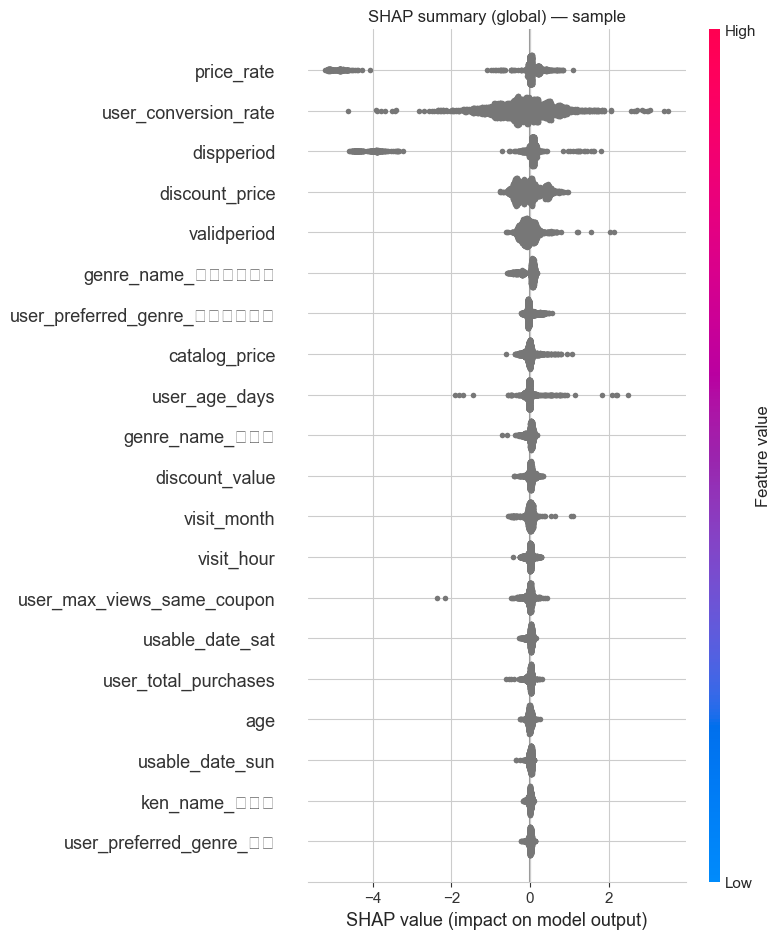

In [5]:
# SHAP global explanation
print("Building SHAP explainer")

# For tree-based models (xgboost, random forest) use TreeExplainer
tree_like = any(t in str(type(model)).lower() for t in ["xgb", "xgboost", "randomforest", "lgbm", "catboost", "xgbclassifier"])
if tree_like:
    # For TreeExplainer we need the preprocessed matrix (raw X passed through pipeline preprocessor)
    # We'll create a small sample to initialize explainer (to keep memory low due to system constraints)
    sample_for_explainer = X.sample(n=min(2000, len(X)), random_state=RND)
    # If pipeline has preprocessor, transform; else pass raw
    if preprocessor is not None:
        sample_matrix = preprocessor.transform(sample_for_explainer)
    else:
        sample_matrix = pipeline[:-1].transform(sample_for_explainer) if hasattr(pipeline, '__len__') else sample_for_explainer.values

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(sample_matrix)  # returns array (n_samples, n_features) or list for multiclass
    # For binary classification XGBoost, shap_values may be array for positive class
    # Plot global summary:
    plt.title("SHAP summary (global) — sample")
    shap.summary_plot(shap_values, sample_matrix, feature_names=feature_names, show=True)
else:
    # Fallback: KernelExplainer on a small subset
    print("Model is not tree-based; using KernelExplainer (slow). Sampling small subset...")
    tiny = X.sample(n=min(200, len(X)), random_state=RND)
    if preprocessor is not None:
        tiny_matrix = preprocessor.transform(tiny)
    else:
        tiny_matrix = tiny.values

    # wrap pipeline.predict_proba for kernel explainer (returns prob of positive class)
    def pred_fn(z):
        # We'll assume this function is used only for small sets
        return pipeline.predict_proba(z)[:, 1]

    explainer = shap.KernelExplainer(pred_fn, tiny_matrix)
    sample_matrix = preprocessor.transform(X.sample(n=min(200, len(X)), random_state=RND)) if preprocessor is not None else X.sample(n=min(200, len(X)), random_state=RND).values
    shap_values = explainer.shap_values(sample_matrix, nsamples=100)
    shap.summary_plot(shap_values, sample_matrix, feature_names=feature_names, show=True)

price_rate                        0.633707
user_conversion_rate              0.604070
dispperiod                        0.538865
discount_price                    0.259074
validperiod                       0.151018
genre_name_ホテル・旅館                 0.120541
user_preferred_genre_ホテル・旅館       0.088577
catalog_price                     0.081671
user_age_days                     0.069029
genre_name_グルメ                    0.059967
discount_value                    0.054764
visit_month                       0.054604
visit_hour                        0.049952
user_max_views_same_coupon        0.047840
usable_date_sat                   0.041857
user_total_purchases              0.039684
age                               0.032929
usable_date_sun                   0.028775
ken_name_東京都                      0.028349
user_preferred_genre_宅配           0.026507
small_area_name_新宿・高田馬場・中野・吉祥寺    0.023358
large_area_name_関東                0.022982
user_preferred_genre_グルメ          0.018067
user_unique

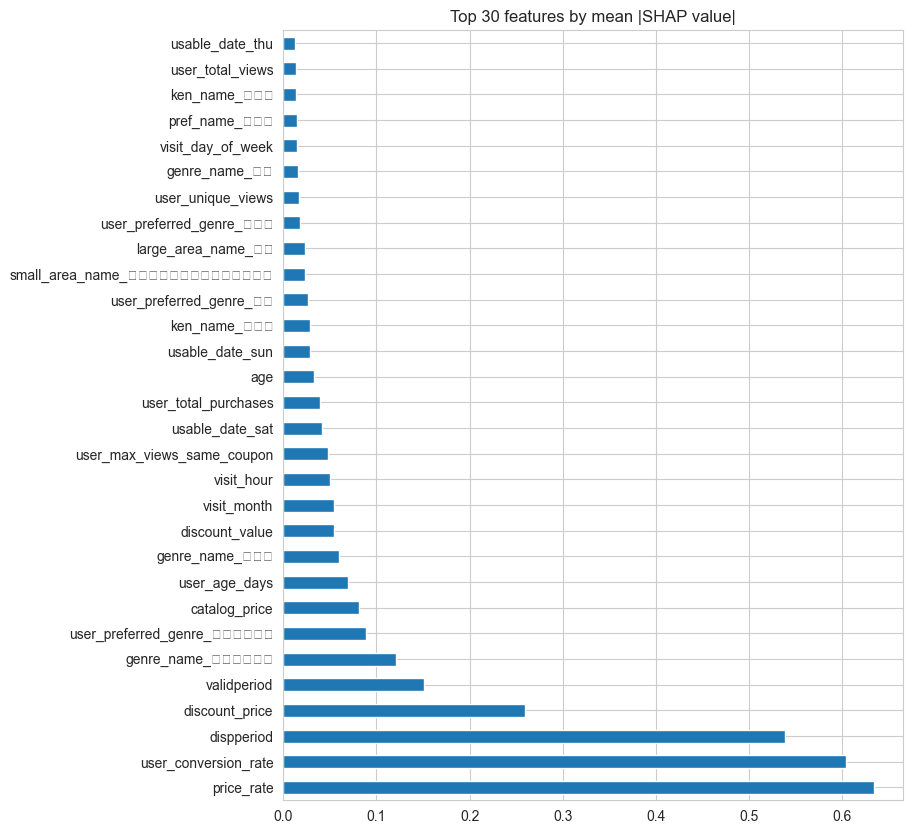

In [6]:
# If shap_values is list (multiclass), pick positive class index 
try:
    sv = shap_values
    # If sv is list (e.g., [neg, pos]), get pos
    if isinstance(sv, list) and len(sv) > 1:
        sv_pos = sv[1]
    else:
        sv_pos = sv
    # Compute mean absolute shap per feature
    mean_abs_shap = np.abs(sv_pos).mean(axis=0)
    fi = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False).head(30)
    display(fi)
    plt.figure(figsize=(8,10))
    fi.sort_values().plot(kind='barh')
    plt.title("Top 30 features by mean |SHAP value|")
    plt.gca().invert_yaxis()
    plt.show()
except Exception as e:
    print("Could not compute SHAP feature importance:", e)

Generating dependence plots...
Found features to plot: ['price_rate', 'discount_value', 'user_conversion_rate', 'user_total_views', 'age']
Plotting dependence for: price_rate


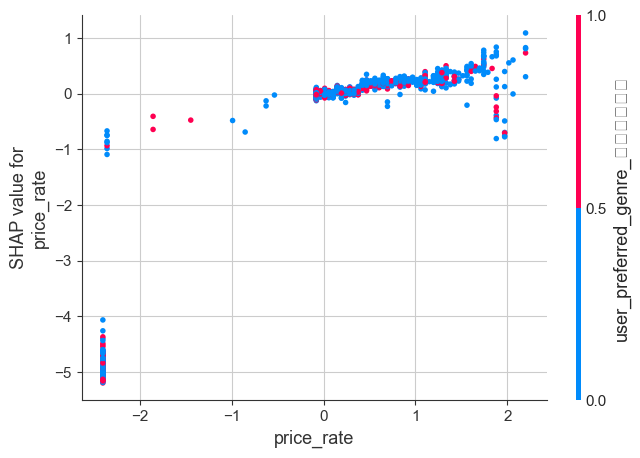

Plotting dependence for: discount_value


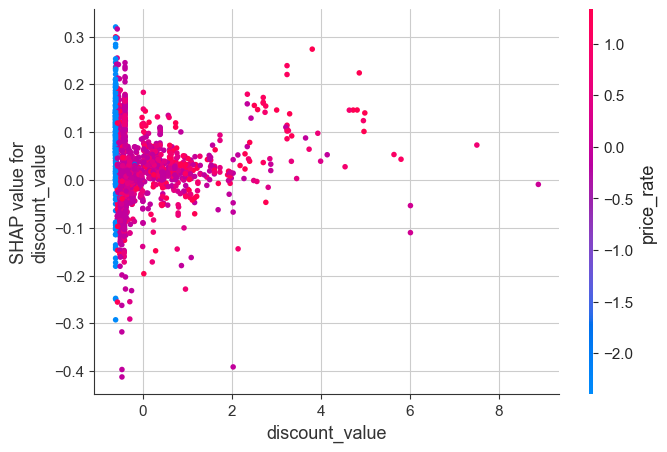

Plotting dependence for: user_conversion_rate


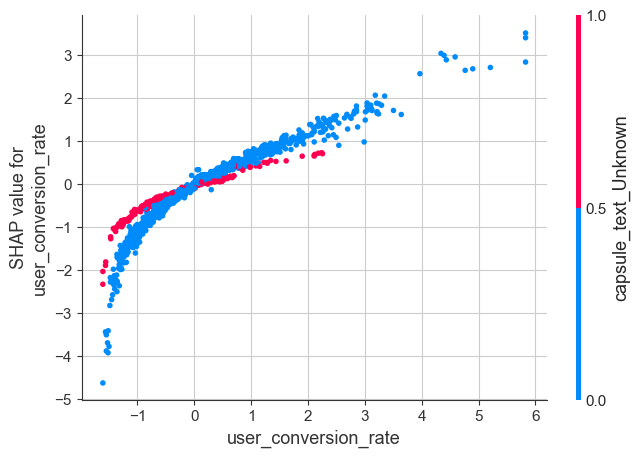

Plotting dependence for: user_total_views


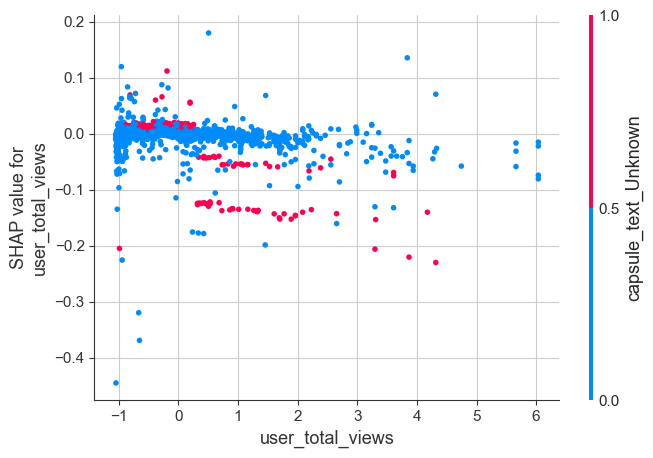

Plotting dependence for: age


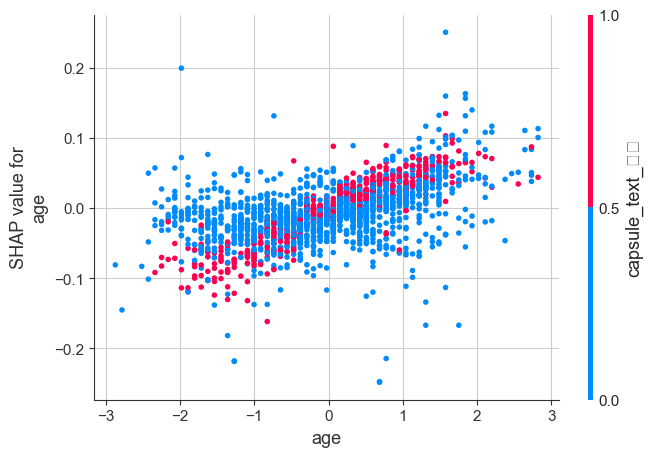

In [9]:
# Cell 7 — SHAP dependence plots
print("Generating dependence plots...")

# 1. CRITICAL FIX: Convert Sparse Matrix to Dense for Plotting
# This will prevent the "sparse array length is ambiguous" error
if hasattr(sample_matrix, 'toarray'):
    sample_matrix_dense = sample_matrix.toarray()
else:
    sample_matrix_dense = sample_matrix

# 2. Define candidates to look for
candidates = ['price_rate', 'discount_value', 'user_conversion_rate', 'user_total_views', 'age']

# 3. Smart Match: Find the actual column name in your feature list
# (Handles cases where names might be "price_rate" OR "num__price_rate")
plot_features = []
for c in candidates:
    if c in feature_names:
        plot_features.append(c)
    else:
        # Try finding it with a prefix if exact match fails
        match = next((f for f in feature_names if c in f), None)
        if match:
            plot_features.append(match)

print("Found features to plot:", plot_features)

# 4. Plot
for f in plot_features:
    print(f"Plotting dependence for: {f}")
    try:
        shap.dependence_plot(f, sv_pos, sample_matrix_dense, feature_names=feature_names, show=True)
    except Exception as e:
        print(f"Could not plot {f}: {e}")

Selecting sample user for explanation...
Explaining a sample for user: d9dca3cb44bab12ba313eaa681f663eb


Generating Force Plot...


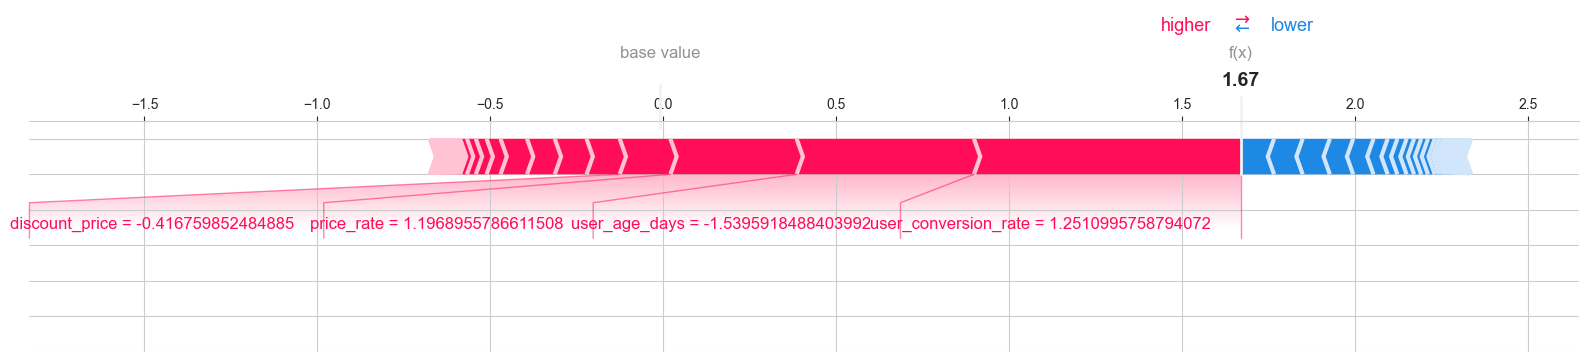

None

In [11]:
# Local explanation for a single user (Fixed for Sparse Matrix)
print("Selecting sample user for explanation...")

# 1. Pick a user_id sample
sample_user = None
if user_id_col is not None:
    # picking a user with at least one positive example
    pos_users = df.loc[df[target_col]==1, user_id_col].unique()
    if len(pos_users)>0:
        sample_user = pos_users[0]
    else:
        sample_user = df[user_id_col].iloc[0]

print("Explaining a sample for user:", sample_user)

# 2. Select a representative row
row = df[df[user_id_col]==sample_user].iloc[0]
row_X = pd.DataFrame([row[feature_cols]])  # raw features as DF

# 3. Preprocess
if preprocessor is not None:
    row_matrix = preprocessor.transform(row_X)
else:
    row_matrix = row_X.values

# This prevents "sparse array length is ambiguous" error
if hasattr(row_matrix, 'toarray'):
    row_matrix_dense = row_matrix.toarray()
else:
    row_matrix_dense = row_matrix

# 5. Calculate and Plot
if tree_like:
    # Calculate SHAP values (Explainer handles sparse fine)
    shap_vals_row = explainer.shap_values(row_matrix)
    
    shap.initjs()
    try:
        # If shap_vals_row is list (binary classification), take positive class
        svr = shap_vals_row[1] if isinstance(shap_vals_row, list) and len(shap_vals_row)>1 else shap_vals_row
        print("Generating Force Plot...")
        display(shap.force_plot(
            explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
            svr[0,:], 
            row_matrix_dense, 
            feature_names=feature_names, 
            matplotlib=True
        ))
    except Exception as e:
        print("Could not show force plot inline:", e)
else:
    print("Local SHAP for non-tree models not implemented in this cell.")

In [12]:
#Probability Calibration (Crucial for Financial Simulation)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

print("--- Calibrating Probabilities ---")
# 1. Create a validation set for calibration
X_train_calib, X_val_calib, y_train_calib, y_val_calib = train_test_split(
    X, y, test_size=0.2, random_state=RND, stratify=y
)

# 2. Wrap the existing pipeline in a Calibrator
calibrated_pipeline = CalibratedClassifierCV(
    estimator=pipeline,
    method='isotonic',
    cv='prefit'
)

# 3. Fit ONLY the calibrator
print("Fitting calibrator on validation subset...")
calibrated_pipeline.fit(X_val_calib, y_val_calib)

# 4. Replace the main pipeline variable
pipeline = calibrated_pipeline
print("Pipeline is now calibrated! Probabilities are safe for financial simulation.")

--- Calibrating Probabilities ---
Fitting calibrator on validation subset...
Pipeline is now calibrated! Probabilities are safe for financial simulation.


In [29]:
# Prescription: Discount simulation function
def simulate_discount_response(pipeline, base_row: pd.Series, price_col='price_rate', price_vals=None, adjust_discount_price=True):
    """
    pipeline: trained pipeline (preprocessor + model)
    base_row: pd.Series of raw features
    price_col: name of the percentage discount feature
    """
    if price_vals is None:
        price_vals = np.arange(0, 101, 5)  # 0% to 100% in steps of 5
    
    rows = []
    for p in price_vals:
        r = base_row.copy()
        
        # LOGIC FIX: Invert the value for the model
        # If we simulate 10% Discount, Price Rate (Paid) is 90%
        if price_col in r.index:
            r[price_col] = 100 - p
            
        # If discount_price exists, try a simple scaling heuristic for consistency:
        if adjust_discount_price and 'discount_price' in r.index and 'catalog_price' in r.index:
            try:
                catalog = float(r['catalog_price'])
                # Discount Price = Catalog * (1 - Discount/100)
                r['discount_price'] = catalog * (1 - p/100.0)
            except Exception:
                pass
        rows.append(r)
        
    df_sim = pd.DataFrame(rows)
    
    # Predict probabilities using the pipeline
    # (This uses the probability calibration from Cell 8.5 if available)
    proba = pipeline.predict_proba(df_sim)[:,1]
    
    df_sim['pred_proba'] = proba
    df_sim['sim_price_rate'] = price_vals
    
    # Return the organized columns
    cols = ['sim_price_rate', 'pred_proba'] + [c for c in df_sim.columns if c not in ['sim_price_rate', 'pred_proba']]
    return df_sim[cols]

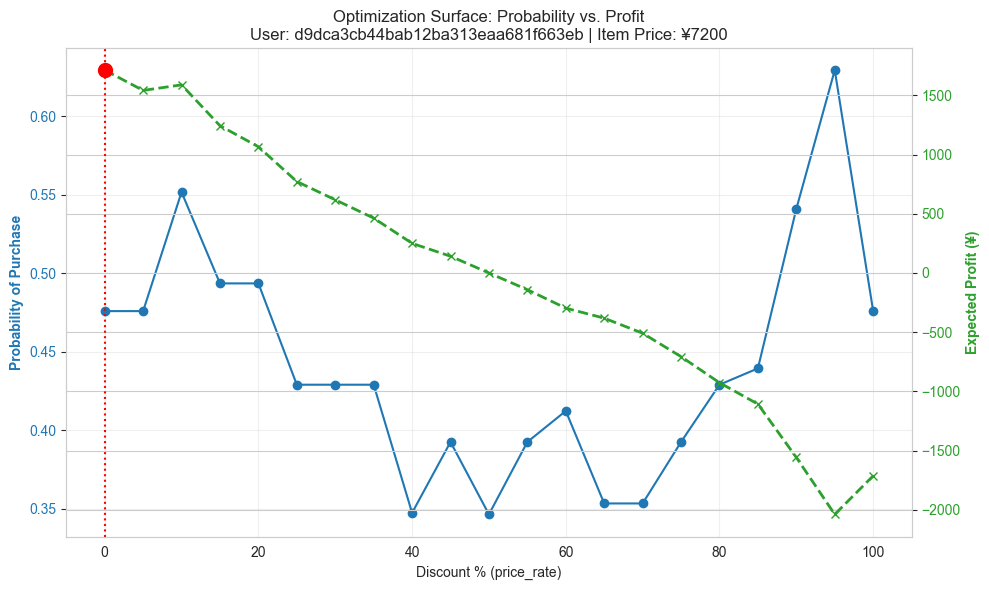

 Optimization Complete.
 Optimal Discount: 0%
 Max Expected Profit: ¥1713.43


In [30]:
# Run simulation and Plot (Robust Indexing)
import matplotlib.pyplot as plt

# 1. Setup Business Rules
ASSUMED_MARGIN_PCT = 0.50  # Rule 2: Assume cost is 50% of catalog price

# 2. Run Simulation
base_row = row[feature_cols]
sim_df = simulate_discount_response(pipeline, base_row, price_col='price_rate')

# 3. Calculate Financials
# Rule 1: Use ACTUAL catalog price from the dataset
catalog_price = float(base_row['catalog_price']) 

# Revenue = Catalog Price * (1 - discount%)
sim_df['revenue_per_unit'] = catalog_price * (1 - sim_df['sim_price_rate'] / 100.0)

# Cost = 50% of Catalog Price (Rule 2)
cost_of_goods = catalog_price * ASSUMED_MARGIN_PCT

# Profit per unit
sim_df['profit_per_unit'] = sim_df['revenue_per_unit'] - cost_of_goods

# Rule 3: EXPECTED Profit = Probability * Profit
sim_df['expected_profit'] = sim_df['pred_proba'] * sim_df['profit_per_unit']

# 4. Find Optimal Discount (Max Expected Profit)
# FIX: Use 'nlargest' to grab the single best row safely, avoiding duplicate index errors
best_row = sim_df.nlargest(1, 'expected_profit').iloc[0]
best_discount = best_row['sim_price_rate']
best_exp_profit = best_row['expected_profit']

# 5. Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Probability (Left Axis - Blue)
color = 'tab:blue'
ax1.set_xlabel('Discount % (price_rate)')
ax1.set_ylabel('Probability of Purchase', color=color, fontweight='bold')
ax1.plot(sim_df['sim_price_rate'], sim_df['pred_proba'], color=color, marker='o', label='Probability')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot Expected Profit (Right Axis - Green)
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Expected Profit (¥)', color=color, fontweight='bold')
ax2.plot(sim_df['sim_price_rate'], sim_df['expected_profit'], color=color, linestyle='--', marker='x', linewidth=2, label='Exp. Profit')
ax2.tick_params(axis='y', labelcolor=color)

# Mark the Optimal Point
plt.axvline(x=best_discount, color='red', linestyle=':', label=f'Optimal: {best_discount}%')
plt.scatter([best_discount], [best_exp_profit], color='red', s=100, zorder=10)

plt.title(f"Optimization Surface: Probability vs. Profit\nUser: {sample_user} | Item Price: ¥{catalog_price:.0f}")
fig.tight_layout()
plt.show()

print(f" Optimization Complete.")
print(f" Optimal Discount: {best_discount}%")
print(f" Max Expected Profit: ¥{best_exp_profit:.2f}")

In [31]:
# CBusiness Recommendation Table (Fixed Index)
# Filter to relevant columns
result_table = sim_df[[
    'sim_price_rate', 
    'pred_proba', 
    'revenue_per_unit', 
    'profit_per_unit', 
    'expected_profit'
]].copy()

# FIX: Reset index to ensure unique row IDs for the Styler
result_table = result_table.reset_index(drop=True)

# Calculate ROI (Return on Investment)
# ROI = Expected Profit / Cost of Goods (Simple retail ROI)
result_table['ROI_pct'] = (result_table['expected_profit'] / cost_of_goods) * 100

# Highlight the optimal row
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

print(f"--- Pricing Strategy Recommendation ---")
print(f"Item Cost: ¥{cost_of_goods:.0f} (50% Margin Assumption)")

# Display top 15 rows styled
# (Now safe to run because indices are unique)
display(result_table.style.apply(highlight_max, subset=['expected_profit', 'ROI_pct']))

# Save to CSV
out_sim_path = f"../data/discount_optimization_{sample_user}.csv"
result_table.to_csv(out_sim_path, index=False)
print(f"Saved optimization table to: {out_sim_path}")

--- Pricing Strategy Recommendation ---
Item Cost: ¥3600 (50% Margin Assumption)


,sim_price_rate,pred_proba,revenue_per_unit,profit_per_unit,expected_profit,ROI_pct
0,0,0.475953,7200.000000,3600.000000,1713.429129,47.595254
1,5,0.475953,6840.000000,3240.000000,1542.086216,42.835728
2,10,0.551695,6480.000000,2880.000000,1588.880711,44.135575
3,15,0.493590,6120.000000,2520.000000,1243.846192,34.551283
4,20,0.493590,5760.000000,2160.000000,1066.153879,29.615386
5,25,0.429106,5400.000000,1800.000000,772.390473,21.455291
6,30,0.429106,5040.000000,1440.000000,617.912378,17.164233
7,35,0.429106,4680.000000,1080.000000,463.434284,12.873175
8,40,0.347532,4320.000000,720.000000,250.222807,6.950634
9,45,0.392659,3960.000000,360.000000,141.357372,3.926594


Saved optimization table to: ../data/discount_optimization_d9dca3cb44bab12ba313eaa681f663eb.csv


In [33]:
# Batch Prescription (Profit Optimized & Cleaned)
def recommend_for_users_profit(pipeline, df_users, user_id_col, price_col='price_rate'):
    rows = []
    print(f"Generating recommendations for {len(df_users)} users...")
    
    for i, uid in enumerate(df_users[user_id_col].unique()):
        try:
            # 1. Get the user's latest view as the "Base Case"
            base = df[df[user_id_col]==uid].sort_values('i_date').iloc[-1]
            
            # 2. SANITY CHECK: Skip invalid items (The Fix)
            catalog_price = float(base['catalog_price'])
            
            # LOGIC: If price is garbage (<= 50), SKIP IT (continue)
            if catalog_price <= 50: 
                continue

            # 3. Run the Simulation (Probabilities)
            sim = simulate_discount_response(pipeline, base[feature_cols], price_col=price_col)
            
            # 4. Calculate Financials
            cost_of_goods = catalog_price * 0.50  # 50% Margin Assumption
            
            # Revenue & Profit per unit
            sim['revenue_per_unit'] = catalog_price * (1 - sim['sim_price_rate'] / 100.0)
            sim['profit_per_unit'] = sim['revenue_per_unit'] - cost_of_goods
            
            # Expected Profit
            sim['expected_profit'] = sim['pred_proba'] * sim['profit_per_unit']
            
            # 5. Pick the Winner (Max Expected Profit)
            best_row = sim.nlargest(1, 'expected_profit').iloc[0]
            
            rows.append({
                "user_id": uid,
                "catalog_price": int(catalog_price),
                "recommended_discount": int(best_row['sim_price_rate']),
                "expected_profit": round(best_row['expected_profit'], 2),
                "predicted_prob": round(best_row['pred_proba'], 4)
            })
        except Exception as e:
            # Silent skip for errors
            pass

    return pd.DataFrame(rows)

# Run for a sample of users (Increased to 100 to ensure we find enough valid ones)
sample_users = df[[user_id_col]].drop_duplicates().head(100)
batch_recs = recommend_for_users_profit(pipeline, sample_users, user_id_col)

print(f"\n--- Valid Recommendations Generated: {len(batch_recs)} ---")
display(batch_recs.head())

# Save to CSV
batch_out_path = "../data/batch_recommendations_profit_optimized.csv"
batch_recs.to_csv(batch_out_path, index=False)
print(f"Saved clean batch recommendations to: {batch_out_path}")

Generating recommendations for 100 users...

--- Valid Recommendations Generated: 85 ---


,user_id,catalog_price,recommended_discount,expected_profit,predicted_prob
0,d9dca3cb44bab12ba313eaa681f663eb,7200,0,1877.41,0.5215
1,560574a339f1b25e57b0221e486907ed,8092,0,2651.92,0.6554
2,e66ae91b978b3229f8fd858c80615b73,2600,5,1153.47,0.9859
3,f430e8302c1fd0915bce0c068ecb2f82,3980,30,231.76,0.2912
4,f3722c3232531440308e8017f28b8cdd,2980,0,991.34,0.6653


Saved clean batch recommendations to: ../data/batch_recommendations_profit_optimized.csv
